In [23]:
import os
import pandas as pd
import glob
import json
import re
import nibabel 
import nilearn
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_anat, plot_img
from nilearn.glm.contrasts import compute_fixed_effects
import matplotlib.pyplot as plt
import numpy as np

In [24]:
#get confounds for any subject and task


def get_confounds(sub,task,ses,run):

    all_confounds = pd.read_csv(f"../../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')
    
    all_confounds_json = open(f"../../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_desc-confounds_timeseries.json")
    all_confounds_json=json.load(all_confounds_json)
    
    
    #typically included rigid body motion (or those plus squares and derivatives if desired, then must comment out top line and uncomment bottom 3)
    motion_params = ['trans_x', 'trans_y', 'trans_z','rot_x','rot_y','rot_z']
    # motion_trans_params = [col for col in all_confounds.columns if 'trans' in col] #change to these squares and derivatives if desired
    # motion_rot_params = [col for col in all_confounds.columns if 'rot' in col] #change to these if desired
    # motion_params=motion_trans_params+motion_rot_params #change to these if desired

    
    #individual col with single 1 for timepoint of motion
    motion_outliers = [col for col in all_confounds.columns if 'motion_outlier' in col]  
    
    
    #for low freq signal drift
    #cannot include this and high-pass temp filter bc already removes low freq fluc
    #required if using aCompCor (or tCompCor)
    cosine_regressors = [col for col in all_confounds.columns if 'cosine' in col] 
    
    
    #these can be adjusted to be from the combined wm csf, for example
    #doesn't make sense to use csf and wm signal regression if using these according to fmriprep documentation
    #6 is rule of thumb; can pick diff number or specific amount of variance explained
    #TO DO clarify if edge/crown regressors are already part of compcor -- unclear in docs and can't find separate regressor in tsv
    num_a_comp_cors=6
    a_comp_cors = []
    for i in range(num_a_comp_cors):
        a_comp_cors.append('a_comp_cor_{:02d}'.format(i))
    
        
    #if taking ICA AROMA denoised niftis (~desc-smoothAROMAnonaggr_bold.nii.gz), can't also include ICA noise regressors & MUST drop non-steady state vols
    #here we are taking instead the ICA AROMA regressors: aroma_motion_XX
    aroma_regressors_all = [col for col in all_confounds.columns if 'aroma' in col]
    aroma_regressors_noise=[]
    for regr in aroma_regressors_all:
        json_name ='aroma_motion_'+str(int(regr.split('aroma_motion_')[1]))
        if all_confounds_json[json_name]['MotionNoise']==True:
            aroma_regressors_noise.append(regr)
        

    #we need to filter out non-steady state volumes if using cosine regressors, ICA AROMA and CompCor regressors...    
    non_steady_state_regressors = [col for col in all_confounds.columns if 'non_steady_state' in col]
    
    
    #TO DO: not sure if CSF should be kept since already have aCompCors
    selected_confounds = all_confounds[['csf','framewise_displacement']+motion_params+motion_outliers+cosine_regressors+a_comp_cors+aroma_regressors_noise+non_steady_state_regressors].copy()

    #get rid of nas in first row of derivative and framewise displacement cols
    for col in selected_confounds.columns:
        if ('derivative' in col) or ('framewise_displacement' in col):
            if pd.isna(selected_confounds[col][0]):
                selected_confounds[col][0]=0

    return selected_confounds



In [25]:
#first level glm model


def run_first_level_model(sub,task,ses,run):
    memory = './nilearn_cache' #change if desired
    space='MNI152NLin6Asym' #change if desired
    
    task_json = open(f"../../../task-{task}_bold.json")
    task_json=json.load(task_json)
    TR=task_json['RepetitionTime']
    
    nifti = glob.glob(f'../../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-unco*run-{run}*{space}*preproc*nii.gz')[0]
    events = glob.glob(f'../../../sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-unco*run-{run}*events.tsv')[0]
    mask = glob.glob(f'../../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-unco*run-{run}*{space}*brain_mask.nii.gz')[0]

    selected_confounds=get_confounds(sub,task,ses,run)

    #choose middle slice as reference since fmriprep default for slice timing correction
    #already accounting for drift and high pass filter with cosine regressors (I believe)
    #might want to change to this at some point: minimize_memory=False
    #spm + derivative + disperson should account for undershoot and slight variances in HRF across ppl/regions
    #satra: twice the voxel resolution, so probs 4
    #satra: signal_scaling look more into it, doesn't affect stats but does affect effect size 
    glm = FirstLevelModel(t_r = TR, mask_img=mask, \
        slice_time_ref=0.5, smoothing_fwhm=6.0, hrf_model='spm + derivative + dispersion', drift_model=None, \
        high_pass=None, drift_order=4, standardize=False, signal_scaling=False, noise_model='ar1', \
        memory=memory, minimize_memory=True, verbose=0, n_jobs=-2)

    fitted_glm = glm.fit(nifti, events=events, confounds=selected_confounds)

    return [fitted_glm, selected_confounds]


In [26]:
#create all desired contrasts

#satra: combine image and arrow regressors because highly collinear!!! can do a correlation matrix of all regressors of design matrix to see if we need to throw out a contrast/subject (anything >0.3 or 0.4 is a high correlation)
#on second thought might be ok to keep them apart

def make_localizer_contrasts_old(design_matrix,task,selected_confounds):
    """ returns a dictionary of contrasts, given the design matrix"""

    # first generate canonical contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    
    
    #initialize dictionary of contrasts desired for analysis of respective task
    final_contrasts={}
    
    #create shorter dictionaries of more relevant contrasts
    if task == 'nback':
        final_contrasts = {'twoback-zeroback': (contrasts['twoback'] - contrasts['zeroback']),
                     'twoback': (contrasts['twoback']),
                     'zeroback': (contrasts['zeroback']),
                    }
    
    if task == 'mid':
        final_contrasts = {'HiRewCue-NeuCue': (contrasts['HiRewCue'] - contrasts['NeuCue']), #high reward anticipation
                     'LoRewCue-NeuCue': (contrasts['LoRewCue'] - contrasts['NeuCue']), #low reward anticipation
                     
                     'HiLossCue-NeuCue': (contrasts['HiLossCue'] - contrasts['NeuCue']), #high loss anticipation
                     'LoLossCue-NeuCue': (contrasts['LoLossCue'] - contrasts['NeuCue']), #low loss anticipation
                     
                     'HiWin-NeuHit': (contrasts['HiWin'] - contrasts['NeuHit']), #high reward outcome cp. to neutral hit
                     'LoWin-NeuHit': (contrasts['LoWin'] - contrasts['NeuHit']), #low reward outcome cp. to neutral hit
                     'HiWin-HiNoWin': (contrasts['HiWin'] - contrasts['HiNoWin']), #high reward outcome cp. to high reward miss
                     'LoWin-LoNoWin': (contrasts['LoWin'] - contrasts['LoNoWin']), #low reward outcome cp. to low reward miss
                     
                     'HiLoss-NeuMiss': (contrasts['HiLoss'] - contrasts['NeuMiss']), #high loss cp. to neutral miss
                     'LoLoss-NeuMiss': (contrasts['LoLoss'] - contrasts['NeuMiss']), #low loss cp. to neutral miss
                     'HiLoss-AvoidHiLoss': (contrasts['HiLoss'] - contrasts['AvoidHiLoss']), #high loss cp. to avoid high loss
                     'LoLoss-AvoidLoLoss': (contrasts['LoLoss'] - contrasts['AvoidLoLoss']), #low loss cp. to avoid low loss
                    
                    
                     'RewCue-NeuCue': (0.5*contrasts['HiRewCue'] + 0.5*contrasts['LoRewCue'] - contrasts['NeuCue']), #combined reward anticipation
                           
                     'LossCue-NeuCue': (0.5*contrasts['HiLossCue'] + 0.5*contrasts['LoLossCue'] - contrasts['NeuCue']), #combined loss anticipation

                     'Win-NeuHit': (0.5*contrasts['HiWin'] + 0.5*contrasts['LoWin'] - contrasts['NeuHit']), #reward outcome cp. to neutral hit               
                     'Win-NoWin': (0.5*contrasts['HiWin'] + 0.5*contrasts['LoWin'] - 0.5*contrasts['HiNoWin'] - 0.5*contrasts['LoNoWin']), #reward outcome cp. to reward miss

                     'Loss-NeuMiss': (0.5*contrasts['HiLoss'] + 0.5*contrasts['LoLoss'] - contrasts['NeuMiss']), #loss cp. to neutral miss
                     'Loss-AvoidLoss': (0.5*contrasts['HiLoss'] + 0.5*contrasts['LoLoss'] - 0.5*contrasts['AvoidHiLoss'] - 0.5*contrasts['AvoidLoLoss']), #loss cp. to avoid loss                                  
                    }
    
    if task == 'sst':
        final_contrasts = {'N_SuccStop_arrow-N_Go_arrow': (contrasts['N_SuccStop_arrow'] - contrasts['N_Go_arrow']), #correct inhibition normal
                     'MJ_SuccStop_arrow-MJ_Go_arrow': (contrasts['MJ_SuccStop_arrow'] - contrasts['MJ_Go_arrow']), #correct inhibition MJ
                     
                     'N_UnsuccStop_arrow-N_Go_arrow': (contrasts['N_UnsuccStop_arrow'] - contrasts['N_Go_arrow']), #incorrect inhibition normal
                     'MJ_UnsuccStop_arrow-MJ_Go_arrow': (contrasts['MJ_UnsuccStop_arrow'] - contrasts['MJ_Go_arrow']), #incorrect inhibition MJ

                     'N_UnsuccStop_arrow-N_SuccStop_arrow': (contrasts['N_UnsuccStop_arrow'] - contrasts['N_SuccStop_arrow']), #succesful inhibitory control normal
                     'MJ_UnsuccStop_arrow-MJ_SuccStop_arrow': (contrasts['MJ_UnsuccStop_arrow'] - contrasts['MJ_SuccStop_arrow']) #succesful inhibitory control MJ
                    }

        
    #add a nuisance regressor contrast to the final set of contrasts that includes all nuisance regressors
    final_contrasts['nuisance_regressors']=np.zeros(design_matrix.shape[1])
    
    for confound in selected_confounds.columns:
        final_contrasts['nuisance_regressors']=final_contrasts['nuisance_regressors']+contrasts[confound]
        
    
    return final_contrasts


In [27]:
make_localizer_contrasts(fitted_glm_sst_1.design_matrices_[0],'sst')

NameError: name 'fitted_glm_sst_1' is not defined

In [14]:
make_localizer_contrasts(fitted_glm_mid_1.design_matrices_[0],'mid')

{'HiRewCue - NeuCue': array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]),
 'LoRewCue - NeuCue': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]),
 'HiLossCue - NeuCue': array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]),


In [56]:
make_localizer_contrasts(fitted_glm_wConf.design_matrices_[0],'nback')

{'twoback': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 'zeroback': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 'two - zero': array([ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.])}

In [8]:
def plot_contrast(glm,task,selected_confounds):
    """ Given a first model, specify, estimate and plot the main contrasts"""
    # Call the contrast specification within the function
    design_matrix = glm.design_matrices_[0]
    contrasts = make_localizer_contrasts(design_matrix,task,selected_confounds)
    fig = plt.figure(figsize=(30, 70))
    # compute the per-contrast z-map
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        ax = plt.subplot(len(contrasts), 1, 1 + index)
        z_map = glm.compute_contrast(contrast_val, output_type='z_score')
        plot_stat_map(z_map, display_mode='z', threshold=3, title=contrast_id, axes=ax,\
                              cut_coords=(0,12,20,28,36,44,52),)

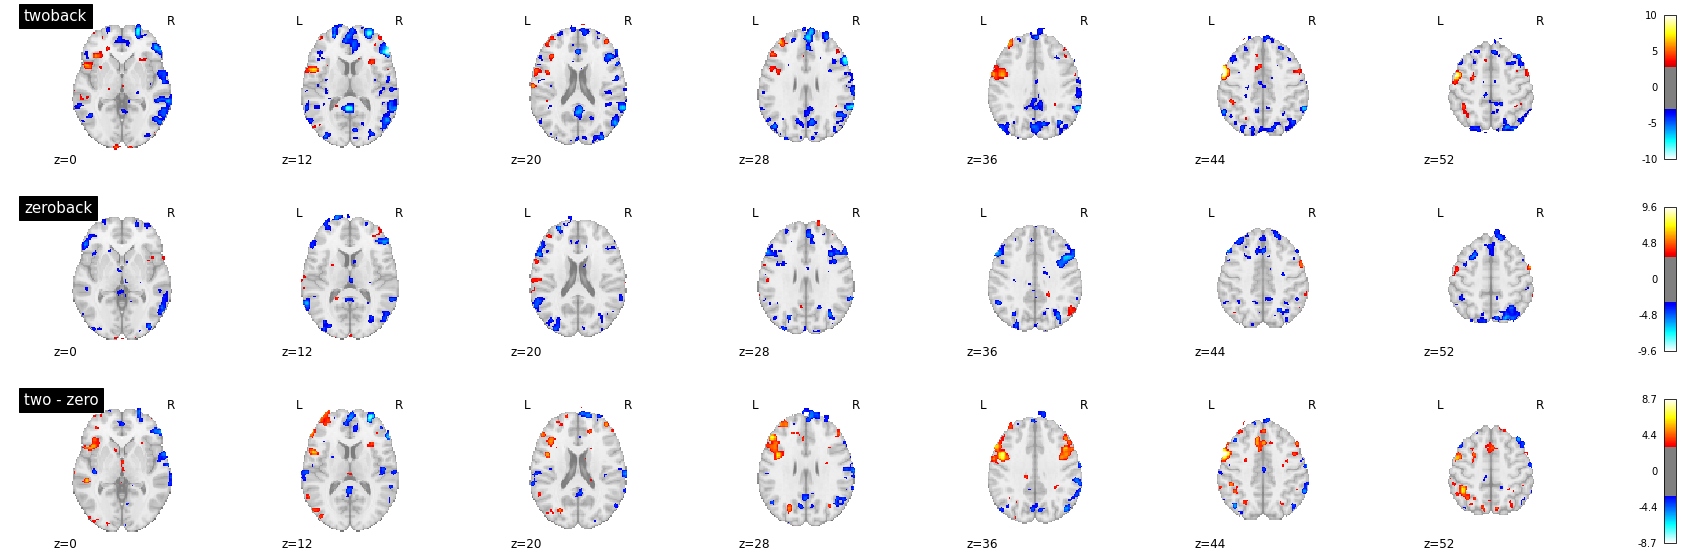

In [49]:
#plotting z values, 3 threshold
plot_contrast(fitted_glm_wConf,'nback')

In [9]:
#plot design matrix for one subject

def show_design_matrix(fitted_glm):
    for design_matrix in fitted_glm.design_matrices_:
        plot_design_matrix(design_matrix)
        plt.show()

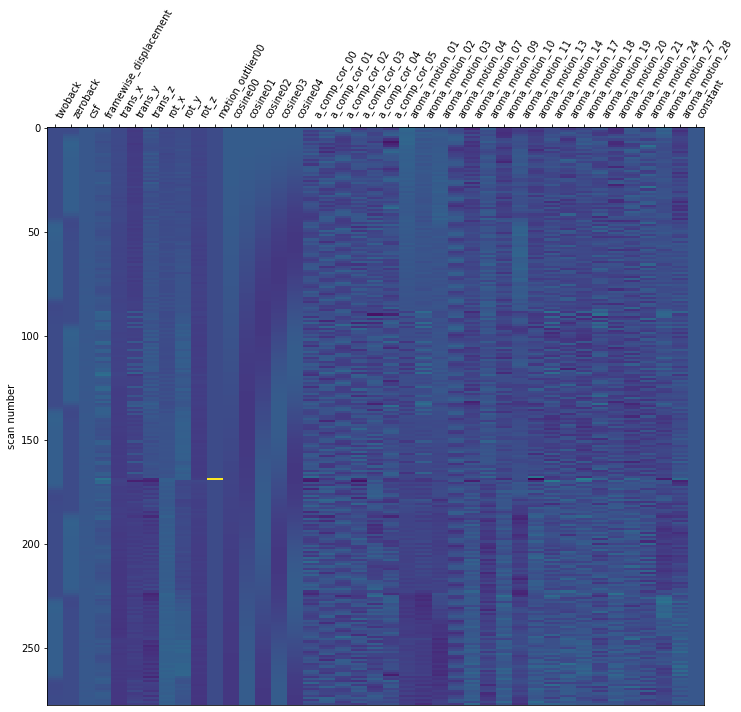

In [25]:
show_design_matrix(fitted_glm_wConf)

(91, 109, 91, 278)


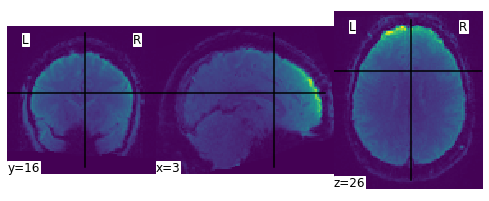

In [14]:
#plotting a single image vol
sub='MM028'
ses='1year'
task='nback'
run='1'

space='MNI152NLin6Asym'
nifti_locations = (glob.glob(f'../../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-unco*run-{run}*{space}*preproc*nii.gz'))
img = nibabel.load(nifti_locations[0])

print(img.shape)

#plot volume 100 out of 278
plot_img(img.slicer[..., 100])

    

In [ ]:
#example code to plot contrast as graph and with HRF overlap

sub='MM028'
ses='1year'
task='mid'
run='1'
#contrast='twoback-zeroback'
space='MNI152NLin6Asym' #change if desired


fitted_glm, selected_confounds=run_first_level_model(sub,task,ses,run)

design_matrix = fitted_glm.design_matrices_[0]

contrasts = make_localizer_contrasts(design_matrix,task,selected_confounds)


            csf  framewise_displacement   trans_x   trans_y   trans_z  \
0    261.235960                0.000000  0.036220 -0.107761 -0.107299   
1    261.475076                0.102581  0.040858 -0.111638 -0.025717   
2    260.400830                0.184124  0.016062 -0.101399 -0.117989   
3    260.592896                0.216461  0.034091 -0.098882 -0.012199   
4    260.382105                0.117995  0.031701 -0.093156 -0.050457   
..          ...                     ...       ...       ...       ...   
210  261.304236                0.162230 -0.118979  0.057297  0.168015   
211  261.669322                0.084509 -0.128894  0.071351  0.145472   
212  262.089752                0.301216 -0.133100 -0.048770  0.219420   
213  260.952211                0.226790 -0.119013 -0.026374  0.111724   
214  261.037738                0.122842 -0.113849  0.059898  0.118825   

        rot_x     rot_y     rot_z  cosine00  cosine01  ...  aroma_motion_12  \
0    0.000277  0.000362  0.000448  0.096446 

In [19]:
from nilearn.reporting import get_clusters_table

z_map=contrast_output['z_score']

table = get_clusters_table(z_map, stat_threshold=3.1, cluster_threshold=20).set_index('Cluster ID', drop=True)
table.head()


,X,Y,Z,Peak Stat,Cluster Size (mm3)
Cluster ID,,,,,
1,-2.0,-4.0,62.0,6.890487,4416
1a,-10.0,-2.0,76.0,4.985428,
1b,-24.0,-28.0,76.0,4.921514,
1c,-14.0,-4.0,70.0,4.902134,
2,4.0,8.0,76.0,6.259647,624


In [20]:
from nilearn.maskers import NiftiSpheresMasker

coords = table.loc[range(1, 7), ['X', 'Y', 'Z']].values

fmri_img=glob.glob(f'../../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-unco*run-{run}*{space}*preproc*nii.gz')[0]


masker = NiftiSpheresMasker(coords)
real_timeseries = masker.fit_transform(fmri_img)
predicted_timeseries = masker.fit_transform(fitted_glm.predicted[0])



________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[145.620671, ..., 154.802449],
       ...,
       [144.304   , ..., 145.953451]]), 
<nibabel.nifti1.Nifti1Image object at 0x2b3ad5a04d60>)


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/maskers/base_masker.py:329: UserWarning: Persisting input arguments took 1.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  img = self._cache(masking.unmask)(X, self.mask_img_)


___________________________________________________________unmask - 7.1s, 0.1min


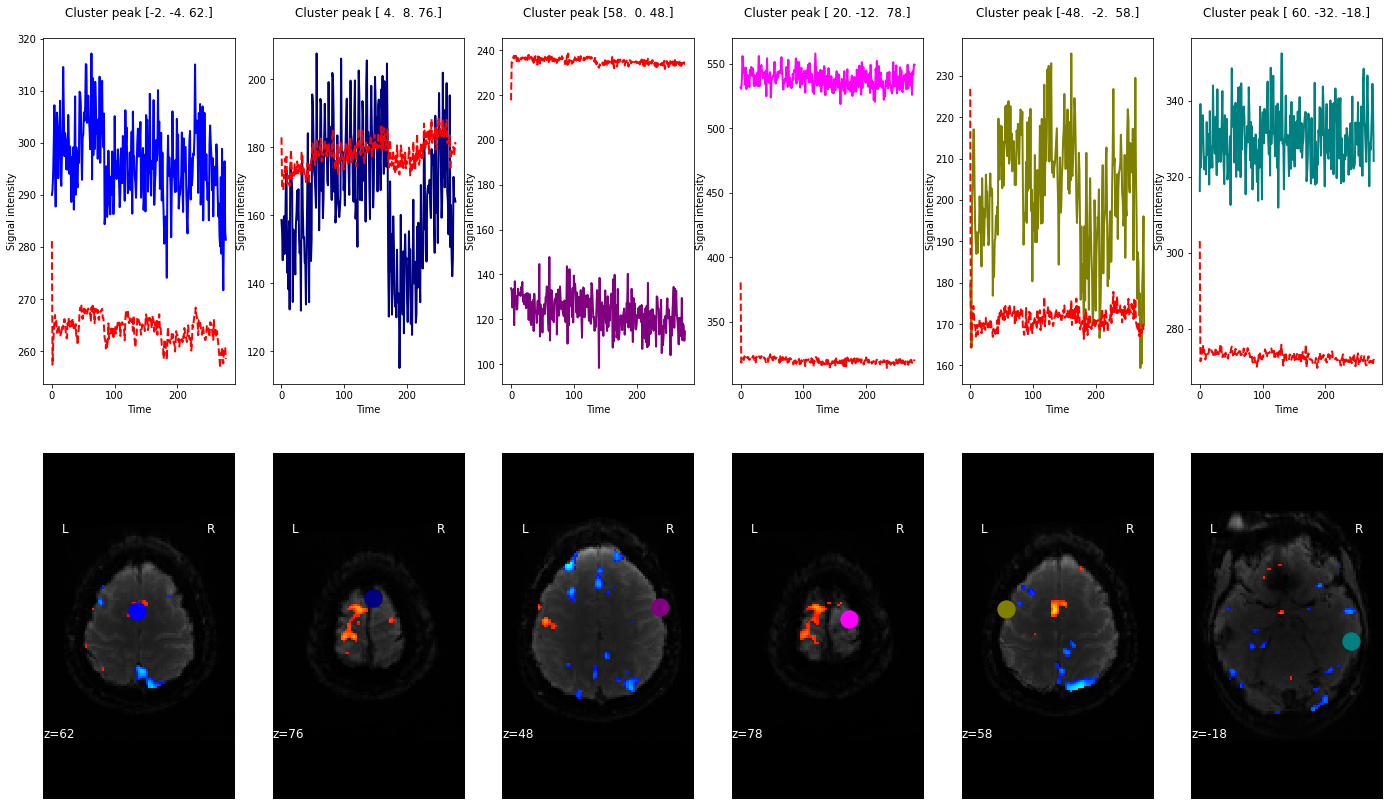

In [21]:
import matplotlib.pyplot as plt
from nilearn.image import mean_img

# niftis=glob.glob(f'../../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-unco*run-*{space}*preproc*nii.gz')
mean_img = mean_img(fmri_img)

# colors for each of the clusters
colors = ['blue', 'navy', 'purple', 'magenta', 'olive', 'teal']
# plot the time series and corresponding locations
fig1, axs1 = plt.subplots(2, 6, figsize=(20, 10))
for i in range(0, 6):
    # plotting time series
    axs1[0, i].set_title('Cluster peak {}\n'.format(coords[i]))
    axs1[0, i].plot(real_timeseries[:, i], c=colors[i], lw=2)
    axs1[0, i].plot(predicted_timeseries[:, i], c='r', ls='--', lw=2)
    axs1[0, i].set_xlabel('Time')
    axs1[0, i].set_ylabel('Signal intensity', labelpad=0)
    # plotting image below the time series
    roi_img = plot_stat_map(
        z_map, cut_coords=[coords[i][2]], threshold=3.1, figure=fig1,
        axes=axs1[1, i], display_mode='z', colorbar=False, bg_img=mean_img)
    roi_img.add_markers([coords[i]], colors[i], 300)
fig1.set_size_inches(24, 14)

In [22]:
fitted_glm.design_matrices_[0].columns

Index(['twoback', 'twoback_derivative', 'twoback_dispersion', 'zeroback',
       'zeroback_derivative', 'zeroback_dispersion', 'csf',
       'framewise_displacement', 'trans_x', 'trans_y', 'trans_z', 'rot_x',
       'rot_y', 'rot_z', 'motion_outlier00', 'cosine00', 'cosine01',
       'cosine02', 'cosine03', 'cosine04', 'a_comp_cor_00', 'a_comp_cor_01',
       'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05',
       'aroma_motion_01', 'aroma_motion_02', 'aroma_motion_03',
       'aroma_motion_04', 'aroma_motion_07', 'aroma_motion_09',
       'aroma_motion_10', 'aroma_motion_11', 'aroma_motion_13',
       'aroma_motion_14', 'aroma_motion_17', 'aroma_motion_18',
       'aroma_motion_19', 'aroma_motion_20', 'aroma_motion_21',
       'aroma_motion_24', 'aroma_motion_27', 'aroma_motion_28', 'dummy_0',
       'dummy_1', 'dummy_2', 'dummy_3', 'dummy_4', 'dummy_5', 'dummy_6',
       'dummy_7', 'dummy_8', 'dummy_9', 'constant'],
      dtype='object')

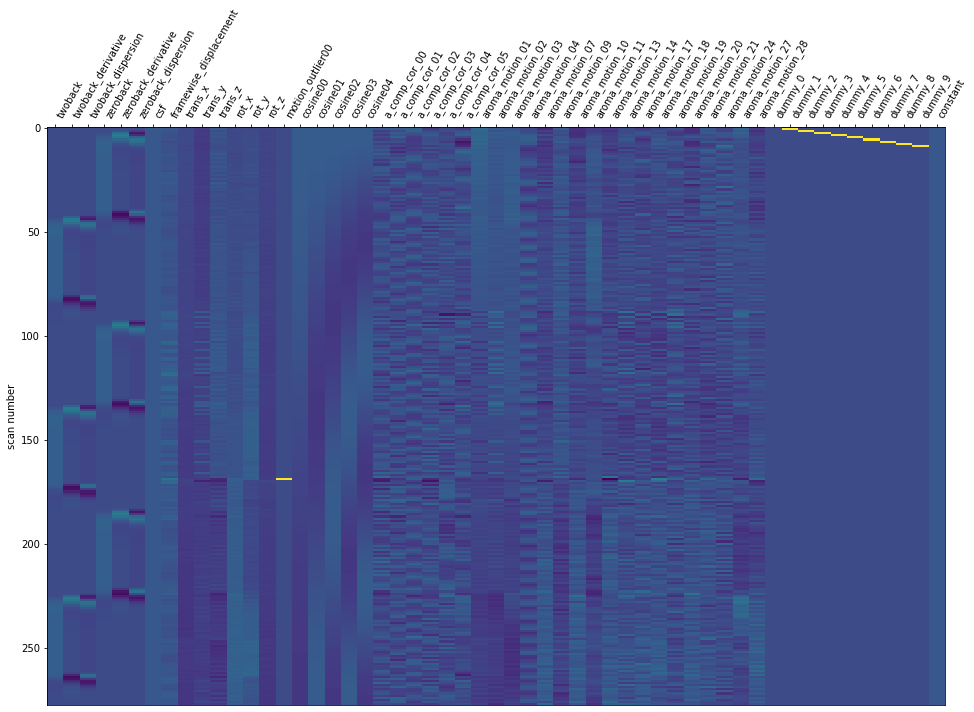

In [23]:
show_design_matrix(fitted_glm)

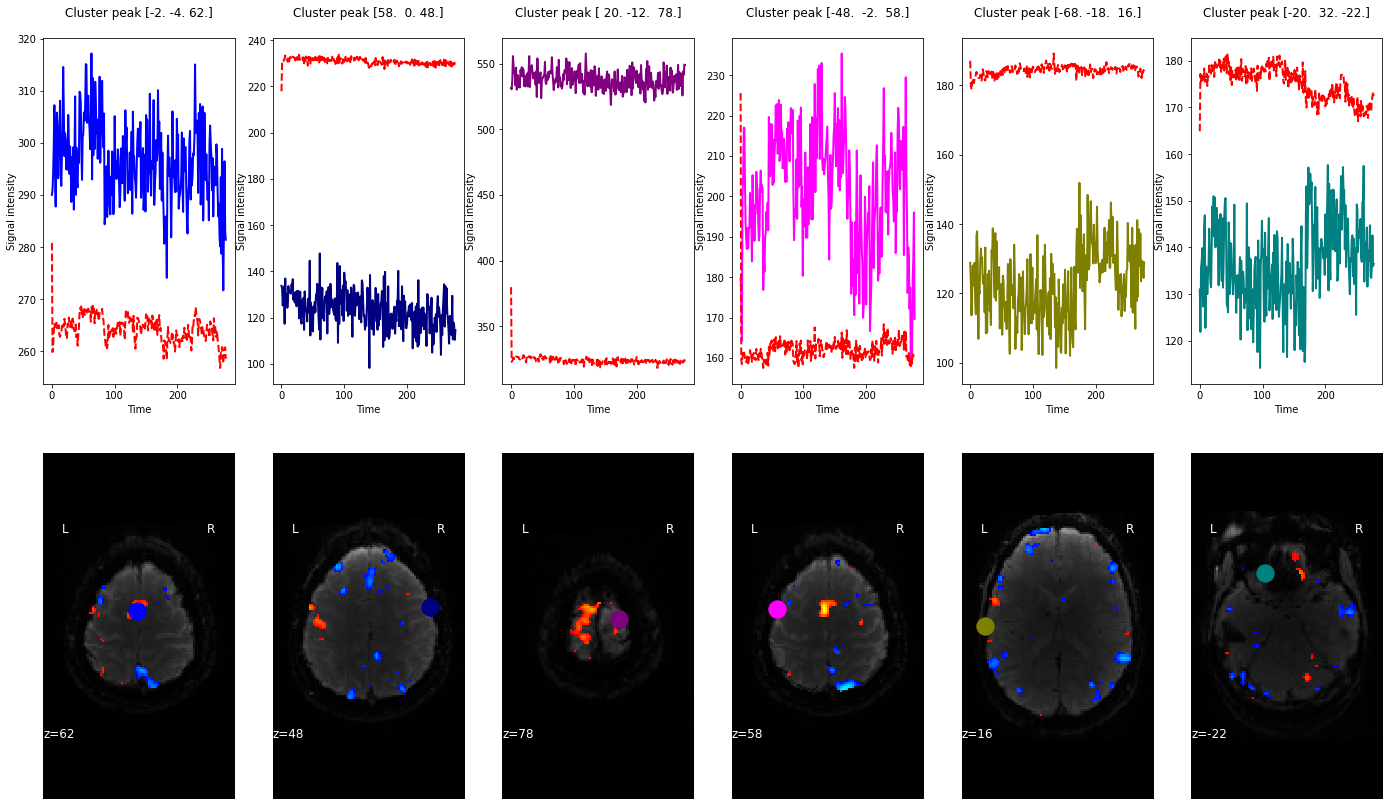

In [20]:
#zeroback

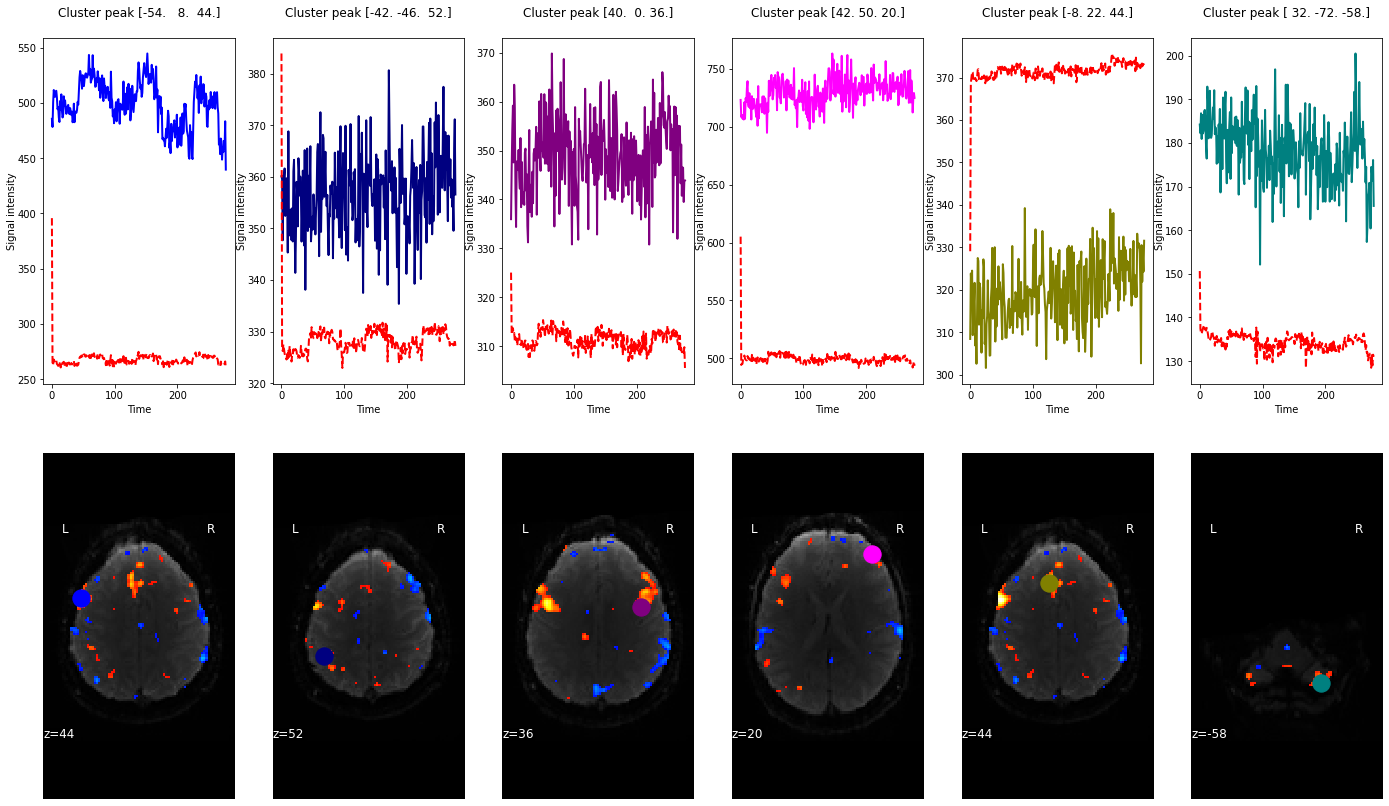

In [22]:
#twoback-zeroback

In [28]:
#create all desired contrasts

#satra: combine image and arrow regressors because highly collinear!!! can do a correlation matrix of all regressors of design matrix to see if we need to throw out a contrast/subject (anything >0.3 or 0.4 is a high correlation)
#on second thought might be ok to keep them apart

def make_localizer_contrasts(design_matrix,task,selected_confounds):
    """ returns a dictionary of contrasts, given the design matrix"""

    # first generate canonical contrasts based on the design matrix columns 
    contrast_matrix = np.eye(design_matrix.shape[1])
    canonical_contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    
    
    #initialize dictionary of contrasts desired for analysis of respective task
    final_contrasts={}
    
    #initialize list of complex contrasts, which are combinations of the canonical contrasts
    task_contrasts = []
    
    #complex contrasts for nback task (must include a '-' or '+' and be made up of canonical contrasts)
    if task == 'nback':
        task_contrasts = ['twoback-zeroback']
    
    #complex contrasts for mid task (must include a '-' or '+' and be made up of canonical contrasts)
    if task == 'mid':
        task_contrasts = ['HiRewCue-NeuCue', #high reward anticipation
                          'LoRewCue-NeuCue', #low reward anticipation
                          'HiLossCue-NeuCue', #high loss anticipation
                          'LoLossCue-NeuCue', #low loss anticipation
                          
                          'HiWin-NeuHit', #high reward outcome cp. to neutral hit
                          'LoWin-NeuHit', #low reward outcome cp. to neutral hit
                          'HiWin-HiNoWin', #high reward outcome cp. to high reward miss
                          'LoWin-LoNoWin', #low reward outcome cp. to low reward miss
                          
                          'HiLoss-NeuMiss', #high loss cp. to neutral miss
                          'LoLoss-NeuMiss', #low loss cp. to neutral miss
                          'HiLoss-AvoidHiLoss', #high loss cp. to avoid high loss
                          'LoLoss-AvoidLoLoss', #low loss cp. to avoid low loss
                          
                          'HiRewCue+LoRewCue-NeuCue', #combined reward anticipation
                          'HiLossCue+LoLossCue-NeuCue', #combined loss anticipation
                          
                          'HiWin+LoWin-NeuHit', #combined reward outcome cp. to neutral hit
                          'HiWin+LoWin-HiNoWin-LoNoWin', #combined reward outcome cp. to combined reward miss
                          
                          'HiLoss+LoLoss-NeuMiss', #combined loss cp. to neutral miss
                          'HiLoss+LoLoss-AvoidHiLoss-AvoidLoLoss' #combined loss cp. to combined avoid loss  
                         ]
    
    #complex contrasts for sst task (must include a '-' or '+' and be made up of canonical contrasts)
    #TO DO: need to add contrasts to capture comparison between MJ trial and Neutral trial for arrow/stop 
    #TO DO: need to add contrasts to capture comparison between MJ trial and Neutral trial for images
#     if task == 'sst':
#         print('here')
#         task_contrasts = ['N_SuccStop_arrow-N_Go_arrow', #correct inhibition normal
#                           'MJ_SuccStop_arrow-MJ_Go_arrow', #correct inhibition MJ
#                           'N_UnsuccStop_arrow-N_Go_arrow', #incorrect inhibition normal
#                           'MJ_UnsuccStop_arrow-MJ_Go_arrow', #incorrect inhibition MJ
#                           'N_UnsuccStop_arrow-N_SuccStop_arrow', #successful inhibitory control normal
#                           'MJ_UnsuccStop_arrow-MJ_SuccStop_arrow' #successful inhibitory control MJ
#                          ]
    
    #for loop that creates complex contrasts based on the string names from the task_contrasts list created above
    for task_contrast in task_contrasts:
        #split complex contrast string into a list of canonical contrasts separated by '-' or '+' 
        #'-' and '+' are maintained in the list due to the () around the deliminator specified in re.split
        events = re.split('([\-\+])', task_contrast)
        
        #check if all canonical contrasts needed for a given complex contrast were present in a subject's data
        #note that sometimes a participant eg. never had a miss on a type of trial, so the miss regressor doesn't exist 
        if len(set(events).intersection(set(canonical_contrasts.keys()))) < np.ceil(len(events)/2):
            print(f'issue with: {task_contrast}')
            continue
        print(f'checking passed for {task_contrast}')
        
        #set up placeholder for array containing matrix for the complex contrast
        complex_contrast = 0
        #set up how the canonical contrasts will be added/subtracted to create the complex contrast
        math_sign = '+'
        plus_multiplier = 1
        minus_multiplier = 1
        #this only applies to the mid task, since the nback and sst tasks' complex contrasts are only made up of two canonical contrasts
        #if mid list consists of 5 elements (i.e. 3 canonical contrasts and 2 math symbols), there is always 1 '+' and 1 '-' (in addition to the implied '+ at the beginning)
        #in that case, we need to multiply the 2 canonical constrasts after the '+' and implied '+' by 0.5
        if len(events) == 5:
            plus_multiplier = 0.5
        #if mid list consists of 7 elements (i.e. 4 canonical contrasts and 3 math symbols), there is always 1 '+' and 2 '-' (in addition to the implied '+ at the beginning)
        #in that case, we need to multiply the 4 canonical constrasts by 0.5
        if len(events) == 7:
            minus_multiplier = 0.5
            plus_multiplier = 0.5
            
        #do the complex contrast calculation
        for el in events:
            #math_sign starts of with '+' as set up above since the first canonical contrast has an implied '+' at the beginning (added to the 0 that we used to initialize the complex contrast)
            if el in ['+','-']:
                math_sign = el
            #if current list element isn't a math sign, then it's a canonical contrast and we add/subtract based on the math sign we set
            #we also multiply the canonical contrast by 1 (default) or 0.5 (certain mid complex contrasts)
            else:
                if math_sign == '+':
                    complex_contrast = complex_contrast + plus_multiplier*canonical_contrasts[el]
                if math_sign == '-':
                    complex_contrast = complex_contrast - minus_multiplier*canonical_contrasts[el]
        #at the end we store the created complex contrast        
        final_contrasts[task_contrast] = complex_contrast       
                
        
    #add a nuisance regressor contrast to the final set of contrasts that includes all nuisance regressors
    #firs set up zeros matrix of correct shape
    final_contrasts['nuisance_regressors']=np.zeros(design_matrix.shape[1])
    #this iteratively adds a 1 in place of all the confounds in the zeros matrix
    for confound in selected_confounds.columns:
        final_contrasts['nuisance_regressors']=final_contrasts['nuisance_regressors']+canonical_contrasts[confound]
    
    #return dictionary of all complex contrasts
    return final_contrasts


In [37]:
#example code to plot contrast as graph and with HRF overlap

sub='MM340'
ses='baseline'
task='mid'
run='1'
#contrast='twoback-zeroback'
space='MNI152NLin6Asym' #change if desired


fitted_glm, selected_confounds=run_first_level_model(sub,task,ses,run)

design_matrix = fitted_glm.design_matrices_[0]

In [38]:
contrasts = make_localizer_contrasts(design_matrix,task,selected_confounds)


checking passed for HiRewCue-NeuCue
checking passed for LoRewCue-NeuCue
checking passed for HiLossCue-NeuCue
checking passed for LoLossCue-NeuCue
checking passed for HiWin-NeuHit
checking passed for LoWin-NeuHit
checking passed for HiWin-HiNoWin
checking passed for LoWin-LoNoWin
checking passed for HiLoss-NeuMiss
checking passed for LoLoss-NeuMiss
checking passed for HiLoss-AvoidHiLoss
checking passed for LoLoss-AvoidLoLoss
checking passed for HiRewCue+LoRewCue-NeuCue
checking passed for HiLossCue+LoLossCue-NeuCue
checking passed for HiWin+LoWin-NeuHit
checking passed for HiWin+LoWin-HiNoWin-LoNoWin
checking passed for HiLoss+LoLoss-NeuMiss
checking passed for HiLoss+LoLoss-AvoidHiLoss-AvoidLoLoss


In [39]:
contrasts

{'HiRewCue-NeuCue': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 'LoRewCue-NeuCue': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [33]:
#contrasts_old = make_localizer_contrasts_old(design_matrix,task,selected_confounds)
#contrasts_old

<AxesSubplot: label='conditions', ylabel='scan number'>

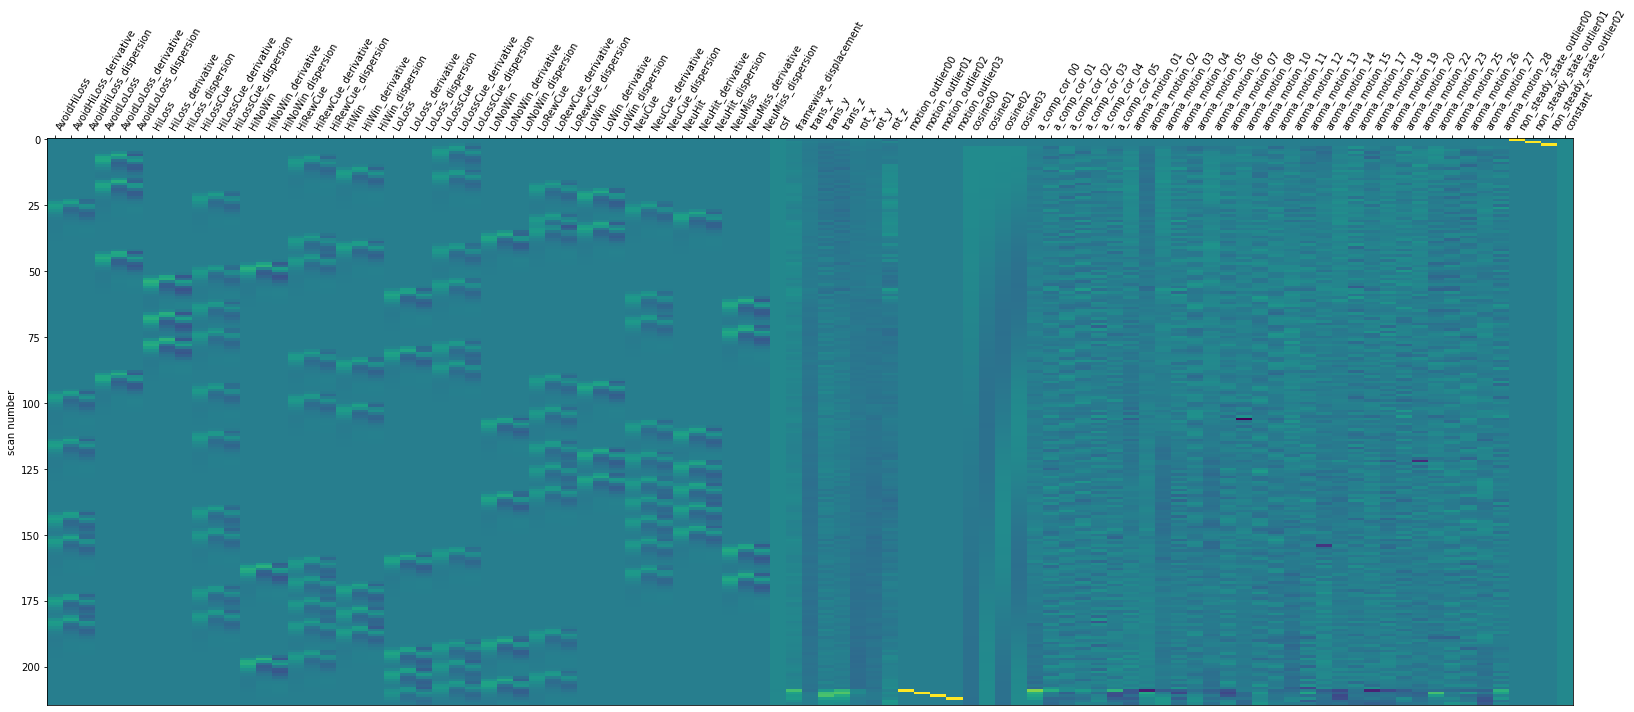

In [40]:
plot_design_matrix(design_matrix)

checking passed for HiRewCue-NeuCue
checking passed for LoRewCue-NeuCue
checking passed for HiLossCue-NeuCue
checking passed for LoLossCue-NeuCue
issue with: HiWin-NeuHit
issue with: LoWin-NeuHit
issue with: HiWin-HiNoWin
issue with: LoWin-LoNoWin
checking passed for HiLoss-NeuMiss
checking passed for LoLoss-NeuMiss
issue with: HiLoss-AvoidHiLoss
issue with: LoLoss-AvoidLoLoss
checking passed for HiRewCue+LoRewCue-NeuCue
checking passed for HiLossCue+LoLossCue-NeuCue
issue with: HiWin+LoWin-NeuHit
issue with: HiWin+LoWin-HiNoWin-LoNoWin
checking passed for HiLoss+LoLoss-NeuMiss
issue with: HiLoss+LoLoss-AvoidHiLoss-AvoidLoLoss
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.3843  , ..., 0.395107]), <nibabel.nifti1.Nifti1Image object at 0x2b6afa65af10>)
___________________________________________________________unmask - 0.2s, 0.0min
________________________________________________________________

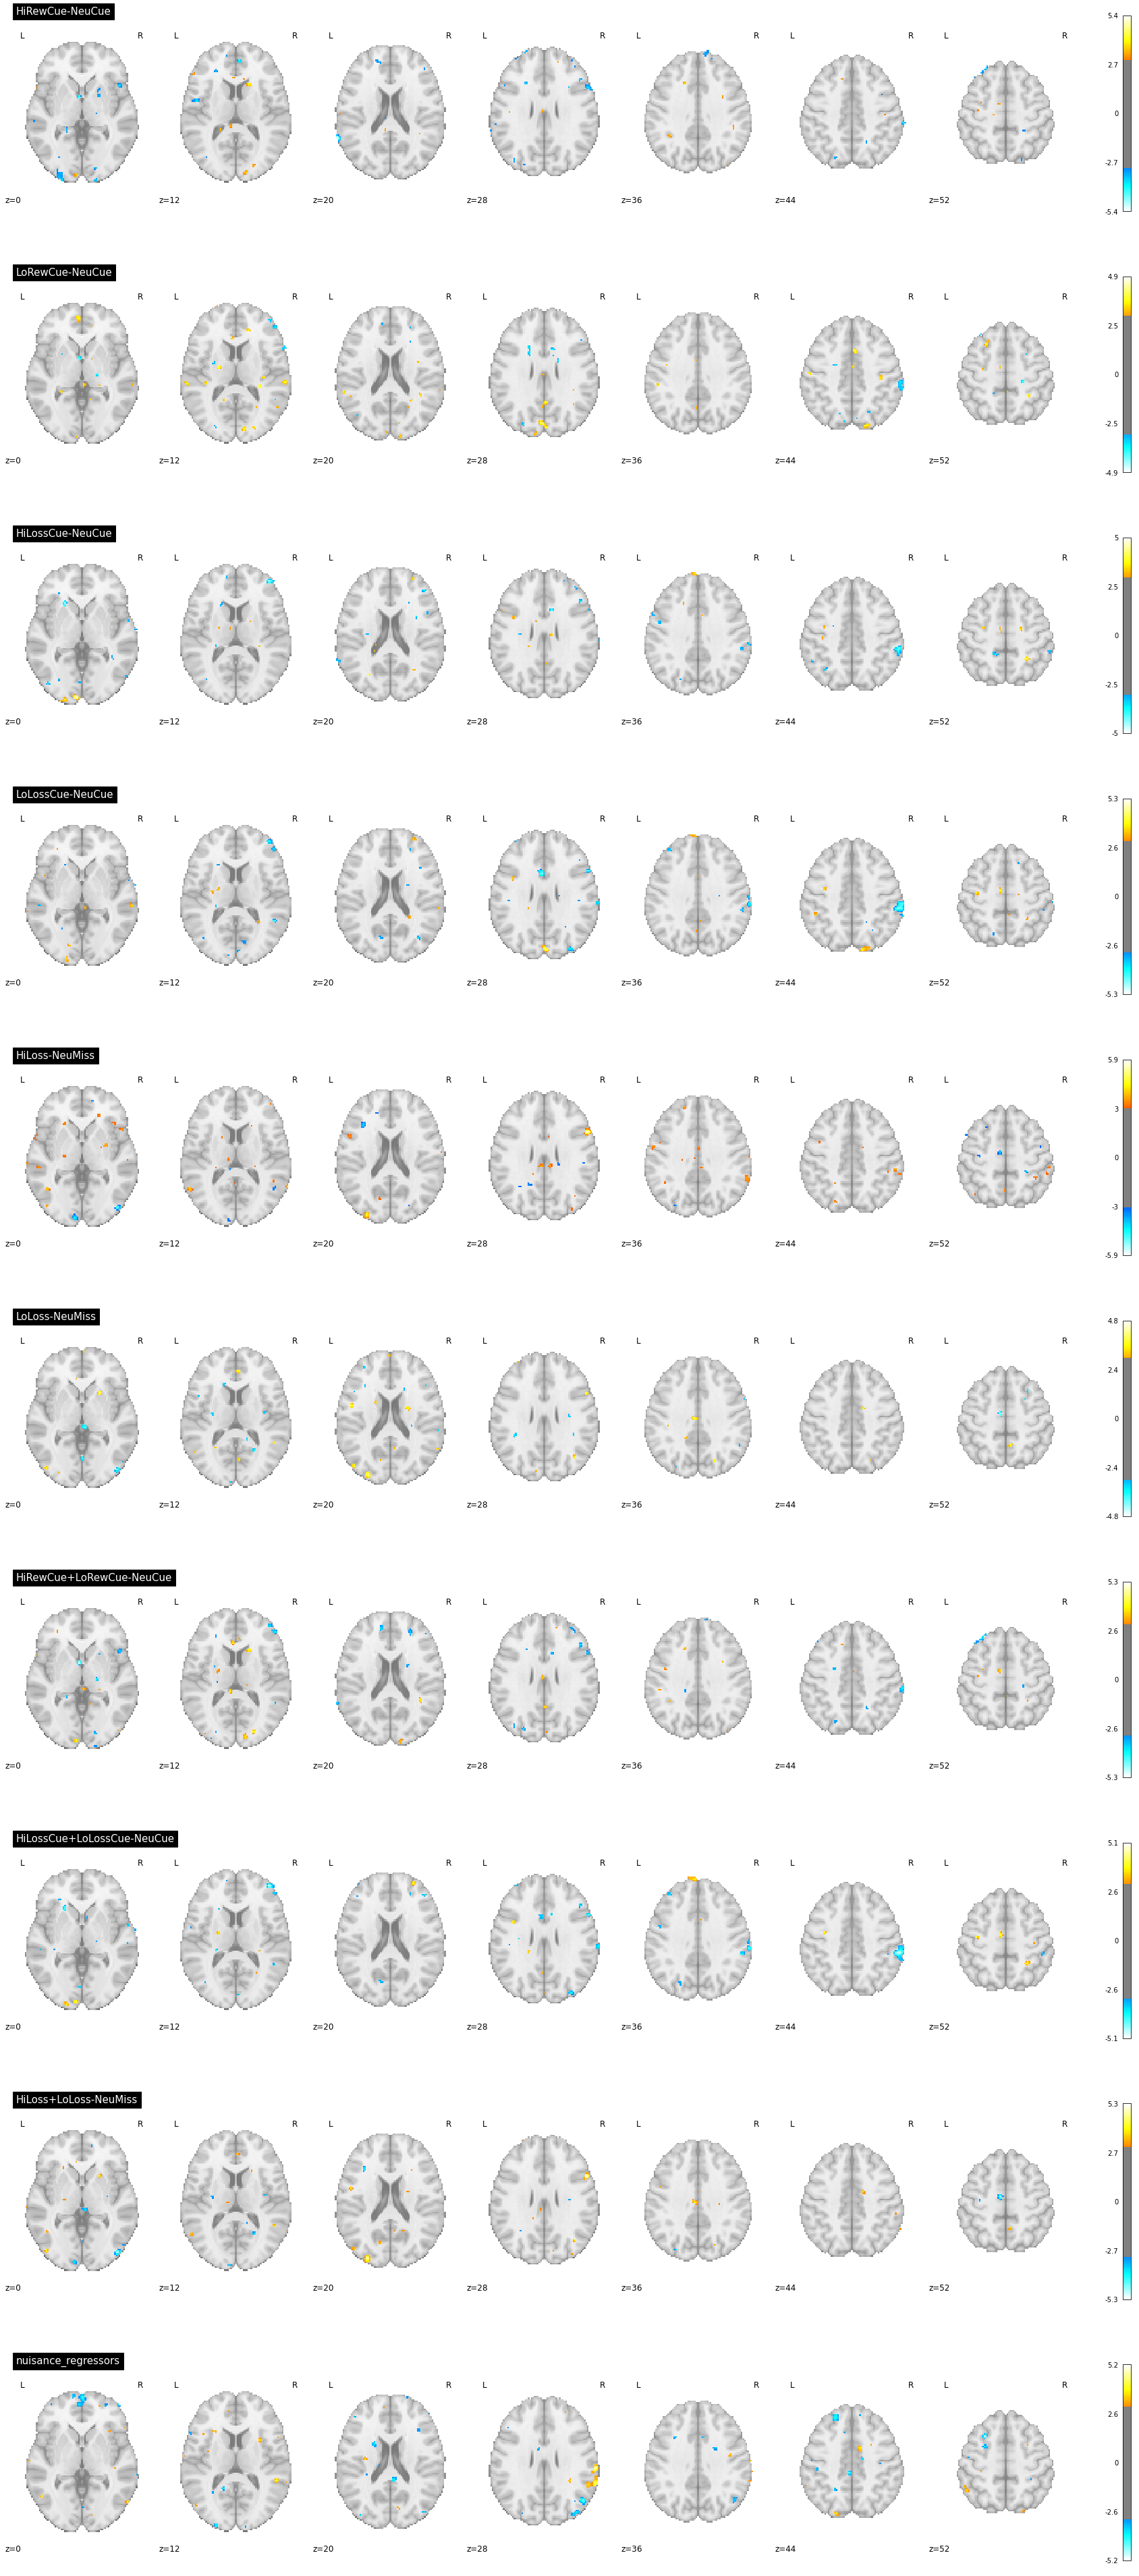

In [20]:
plot_contrast(fitted_glm,task,selected_confounds)

In [35]:
#check for existence of confounds

all_confounds_files = glob.glob("../../../derivatives/ses-*/sub-*/ses-*/func/sub-*_ses-*_task-*_rec-unco_run-*_desc-confounds_timeseries.tsv")

for file in all_confounds_files:
    all_confounds = pd.read_csv(file, sep = '\t')
    #regressors = [col for col in all_confounds.columns if ('comp_cor' in col) and ('y_comp_cor' not in col) and ('t_comp_cor' not in col) and ('c_comp_cor' not in col) and ('w_comp_cor' not in col)]
    #regressors = [col for col in all_confounds.columns if ('edge_comp_' in col)]
    regressors = [col for col in all_confounds.columns if ('non_steady_state' in col)] 
    if regressors:
        #print(file)
        print(regressors)
    
    

../../../derivatives/ses-1year/sub-MM028/ses-1year/func/sub-MM028_ses-1year_task-mid_rec-unco_run-2_desc-confounds_timeseries.tsv
['non_steady_state_outlier00']
../../../derivatives/ses-1year/sub-MM028/ses-1year/func/sub-MM028_ses-1year_task-sst_rec-unco_run-2_desc-confounds_timeseries.tsv
['non_steady_state_outlier00']
../../../derivatives/ses-1year/sub-MM053/ses-1year/func/sub-MM053_ses-1year_task-sst_rec-unco_run-2_desc-confounds_timeseries.tsv
['non_steady_state_outlier00', 'non_steady_state_outlier01']
../../../derivatives/ses-1year/sub-MM100/ses-1year/func/sub-MM100_ses-1year_task-sst_rec-unco_run-2_desc-confounds_timeseries.tsv
['non_steady_state_outlier00']
../../../derivatives/ses-1year/sub-MM122/ses-1year/func/sub-MM122_ses-1year_task-nback_rec-unco_run-1_desc-confounds_timeseries.tsv
['non_steady_state_outlier00', 'non_steady_state_outlier01']
../../../derivatives/ses-1year/sub-MM132/ses-1year/func/sub-MM132_ses-1year_task-mid_rec-unco_run-1_desc-confounds_timeseries.tsv
['n

../../../derivatives/ses-baseline/sub-MM314/ses-baseline/func/sub-MM314_ses-baseline_task-mid_rec-unco_run-2_desc-confounds_timeseries.tsv
['non_steady_state_outlier00', 'non_steady_state_outlier01', 'non_steady_state_outlier02', 'non_steady_state_outlier03']
../../../derivatives/ses-baseline/sub-MM330/ses-baseline/func/sub-MM330_ses-baseline_task-nback_rec-unco_run-1_desc-confounds_timeseries.tsv
['non_steady_state_outlier00', 'non_steady_state_outlier01']
../../../derivatives/ses-baseline/sub-MM340/ses-baseline/func/sub-MM340_ses-baseline_task-mid_rec-unco_run-1_desc-confounds_timeseries.tsv
['non_steady_state_outlier00', 'non_steady_state_outlier01', 'non_steady_state_outlier02']
